# MITSUI&CO. Commodity Prediction Challenge

- Implementing a baseline XGBoost model to predict commodity return differences.
- The goal is to maximize the rank correlation Sharpe ratio.

In [2]:
# !pip install xgboost pandas numpy scikit-learn matplotlib seaborn polars optuna

In [3]:
# Imports
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import polars as pl
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set device
try:
    xgb_gpu_test = xgb.XGBRegressor(tree_method='gpu_hist')
    xgb_gpu_test.fit(np.array([[1,2], [3,4]]), np.array([1,2]))
    GPU_AVAILABLE = True
    print("GPU")
except:
    GPU_AVAILABLE = False
    print("CPU")

GPU


### Evaluation Metric Implementation

In [7]:
# Define function to compute evaluation metric
SOLUTION_NULL_FILLER = -999999

def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]

    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            return 0.0  
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            return 0.0  
        return np.corrcoef(row[matching_predictions].rank(method='average'), 
                          row[non_null_targets].rank(method='average'))[0, 1]

    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    
    # Handle cases where all correlations are 0
    if daily_rank_corrs.std(ddof=0) == 0:
        return daily_rank_corrs.mean()
    
    sharpe_ratio = daily_rank_corrs.mean() / daily_rank_corrs.std(ddof=0)
    return float(sharpe_ratio)

def competition_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    if row_id_column_name in solution.columns:
        del solution[row_id_column_name]
    if row_id_column_name in submission.columns:
        del submission[row_id_column_name]
    
    # Ensure both dataframes have the same columns
    common_cols = list(set(solution.columns) & set(submission.columns))
    solution = solution[common_cols]
    submission = submission[common_cols]
    
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(SOLUTION_NULL_FILLER, None)
    
    # Drop rows where all targets are null
    valid_rows = ~solution.isnull().all(axis=1)
    solution = solution[valid_rows]
    submission = submission[valid_rows]
    
    if len(solution) == 0:
        return 0.0
    
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

# Custom scorer for sklearn
def sharpe_ratio_scorer(y_true, y_pred):
    # Create a DataFrame with target columns
    solution = pd.DataFrame(y_true)
    solution.columns = [f'target_{i}' for i in range(y_true.shape[1])]
    
    # Create submission with same structure
    submission = pd.DataFrame(y_pred)
    submission.columns = [f'target_{i}' for i in range(y_pred.shape[1])]
    
    # Add row_id for compatibility
    solution['row_id'] = range(len(solution))
    submission['row_id'] = range(len(submission))
    
    return competition_score(solution, submission, 'row_id')

# Make it a scorer object
competition_scorer = make_scorer(sharpe_ratio_scorer, greater_is_better=True)

print("Evaluation metric functions loaded")

Evaluation metric functions loaded


### Data Loading and Initial Inspection

In [10]:
# Load datasets 
def load_data():
  
    # Load training data
    train = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train.csv')
    train_labels = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv')
    target_pairs = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/target_pairs.csv')
    
    # Load test data
    test = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/test.csv')
    return train, train_labels, target_pairs, test

# Inspect respective shapes of loaded datasets
train, train_labels, target_pairs, test = load_data()
print(f"\n Training data shape: {train.shape}")
print(f" Training labels shape: {train_labels.shape}")
print(f" Target pairs info: {target_pairs.shape} rows")
print(f"\n Test data shape: {test.shape}")

In [12]:
train.head(3)

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037


In [13]:
train_labels.head(3)

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.005948,-0.002851,-0.004675,-0.000639,NaN,NaN,-0.006729,0.006066,NaN,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,2,0.001048,0.023836,-0.008934,-0.022060,NaN,NaN,0.037449,0.007658,NaN,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706


In [15]:
target_pairs.head(3)

,target,lag,pair
0,target_0,1,US_Stock_VT_adj_close
1,target_1,1,LME_PB_Close - US_Stock_VT_adj_close
2,target_2,1,LME_CA_Close - LME_ZS_Close


In [16]:
test.head(3)

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP,is_scored
0,1827,2684.5,9190.0,1967.0,2942.0,13623.0,13920.0,13618.0,4696.0,4692.0,...,0.631633,0.808485,0.510666,0.051733,0.071654,0.079797,0.048828,13.631347,0.043845,True
1,1828,2691.5,9275.0,1985.0,2963.5,13640.0,13922.0,13634.0,4613.0,4613.0,...,0.633526,0.812571,0.514785,0.051802,0.071793,0.080214,0.048912,13.743387,0.043778,True
2,1829,2646.0,9284.5,1971.0,2914.0,13634.0,13923.0,13638.0,4647.0,4632.0,...,0.632156,0.811948,0.513278,0.051902,0.071630,0.080134,0.048971,13.766241,0.043774,True


### Data Cleaning and Preprocessing

In [22]:
# Define function to clean the train, train_labels, and target_pairs datasets
def clean_data(train, train_labels, target_pairs):
    # Check for missing values
    print("\n Missing values in train data:")
    missing_train = train.isnull().sum()
    print(missing_train[missing_train > 0])
    
    print("\n Missing values in train labels:")
    missing_labels = train_labels.isnull().sum()
    print(missing_labels[missing_labels > 0])
    
    # Handle missing values in train data
    print("\n Handling missing values...")
    train_clean = train.copy()
    
    # Fill date-related features
    if 'date' in train_clean.columns:
        train_clean['date'] = pd.to_datetime(train_clean['date'])
        train_clean = train_clean.sort_values('date')
    
    # Forward fill for time series continuity
    train_clean = train_clean.fillna(method='ffill')
    # Then backfill any remaining at the beginning
    train_clean = train_clean.fillna(method='bfill')
    
    # Check for duplicates
    duplicates = train_clean.duplicated().sum()
    print(f"\n Found {duplicates} duplicate rows - removing...")
    train_clean = train_clean.drop_duplicates()
    
    # Handle outliers using IQR method
    print("\n Handling outliers...")
    numeric_cols = train_clean.select_dtypes(include=[np.number]).columns
    train_clean_no_outliers = train_clean.copy()
    
    for col in numeric_cols:
        Q1 = train_clean[col].quantile(0.01)
        Q3 = train_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = ((train_clean[col] < lower_bound) | (train_clean[col] > upper_bound)).sum()
        if outliers > 0:
            print(f"  Column '{col}': {outliers} outliers detected")
            
            # Cap outliers instead of removing
            train_clean_no_outliers[col] = train_clean[col].clip(lower_bound, upper_bound)
    
    # Check label data
    print("\n Label data statistics:")
    print(train_labels.describe().T.head())
    
    # Verify target pairs
    print("\n Target pairs info:")
    # print(f"Unique asset combinations: {len(target_pairs[['asset1', 'asset2']].drop_duplicates())}")
    # print(f"Calculation types: {target_pairs['calculation'].value_counts().to_dict()}")
    
    # Align train and label data
    if 'date' in train_clean_no_outliers.columns and len(train_clean_no_outliers) == len(train_labels):
        print("\n Aligning train and label data by date")
        
        # Set the date feature as the indexn
        train_clean_no_outliers = train_clean_no_outliers.reset_index(drop=True)
        train_labels = train_labels.reset_index(drop=True)
    
    print("\n Data cleaning completed!")
    return train_clean_no_outliers, train_labels, target_pairs

# Clean the train, train_labels, and target_pairs datasets
train_clean, train_labels, target_pairs = clean_data(train, train_labels, target_pairs)

### Exploratory Data Analysis 

In [26]:
# Define function to perform EDA on train, train_labels, and target_pairs datasets
def perform_eda(train, train_labels, target_pairs):
    # Basic dataset information
    print(f"Training features: {train.shape[0]} samples, {train.shape[1]} features")
    print(f"Training labels: {train_labels.shape[0]} samples, {train_labels.shape[1]} targets")
    
    # Feature distributions
    print("\n Numeric Features Distributions")
    numeric_cols = train.select_dtypes(include=[np.number]).columns[:5]
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(train[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    # Perform correlation analysis
    print("\n Compute feature correlations")
    # Sample a subset to plot a correlation matrix
    sample_size = min(1000, len(train))
    sample_train = train.sample(sample_size, random_state=42)
    
    # Select top 10 numeric features 
    numeric_cols = sample_train.select_dtypes(include=[np.number]).columns[:10]
    corr_matrix = sample_train[numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Feature Correlation Matrix (First 10 Features)')
    plt.tight_layout()
    plt.show()
    
    # Analyze Target variables
    print("\n Analyze target variables")
    # Sample targets for visualization
    sample_targets = train_labels.sample(sample_size, random_state=42)
    
    # Plot distribution of first 5 targets
    plt.figure(figsize=(15, 10))
    for i in range(5):
        if i < sample_targets.shape[1]: 
            plt.subplot(2, 3, i+1)
            sns.histplot(sample_targets[f'target_{i}'], kde=True)
            plt.title(f'Distribution of target_{i}')
    plt.tight_layout()
    plt.show()
    
    # Perform Time series analysis 
    if 'date' in train.columns:
        print("\n Performing time series analysis...")
        train_with_date = train.copy()
        train_with_date['date'] = pd.to_datetime(train_with_date['date'])
        train_with_date = train_with_date.set_index('date')
        
        plt.figure(figsize=(14, 10))
        for i, col in enumerate(numeric_cols[:3], 1):
            plt.subplot(3, 1, i)
            plt.plot(train_with_date.index, train_with_date[col])
            plt.title(f'Time Series: {col}')
            plt.tight_layout()
        plt.show()
    
    # # perform Target Pair Analysis
    # print("\n Analyze target pairs")
    # plt.figure(figsize=(10, 6))
    # target_pairs['asset1'].value_counts().plot(kind='bar')
    # plt.title('Distribution of Asset 1 in Target Pairs')
    # plt.tight_layout()
    # plt.show()
    
    # Compute and display the competition metric on a random prediction
    print("\n Calculate baseline competition metric for random predictions)")
    random_preds = np.random.randn(len(train_labels), train_labels.shape[1])
    solution_df = train_labels.copy()
    submission_df = pd.DataFrame(random_preds, columns=train_labels.columns)
    
    # Add row_id for the metric function
    solution_df['row_id'] = range(len(solution_df))
    submission_df['row_id'] = range(len(submission_df))
    baseline_score = competition_score(solution_df, submission_df, 'row_id')
    print(f"Baseline random prediction score (Sharpe ratio): {baseline_score:.4f}")

# Perform EDA on cleaned train, train_labels, and target_pairs datasets
perform_eda(train_clean, train_labels, target_pairs)

### Feature Engineering

In [40]:
# Define function to perform feature engineering
def feature_engineering(train, train_labels):
    train_eng = train.copy()
    
    # Date-based features (if date column exists)
    if 'date' in train_eng.columns:
        print("Create date-based features")
        train_eng['date'] = pd.to_datetime(train_eng['date'])
        train_eng['day_of_week'] = train_eng['date'].dt.dayofweek
        train_eng['month'] = train_eng['date'].dt.month
        train_eng['quarter'] = train_eng['date'].dt.quarter
        train_eng['is_weekend'] = train_eng['day_of_week'].isin([5, 6]).astype(int)
        
        # Drop the original date column
        train_eng = train_eng.drop('date', axis=1)
    
    # Technical indicators for numeric features
    print(" Create technical indicators")
    numeric_cols = train_eng.select_dtypes(include=[np.number]).columns
    
    # Moving averages for key features
    for col in numeric_cols[:10]:  
        train_eng[f'{col}_ma_5'] = train_eng[col].rolling(window=5, min_periods=1).mean()
        train_eng[f'{col}_ma_20'] = train_eng[col].rolling(window=20, min_periods=1).mean()
        train_eng[f'{col}_vol_20'] = train_eng[col].rolling(window=20, min_periods=1).std()
        train_eng[f'{col}_mom_10'] = train_eng[col].diff(10)
    
    # Cross-feature interactions
    print(" Create cross-feature interactions")
    for i in range(min(5, len(numeric_cols))):
        for j in range(i+1, min(8, len(numeric_cols))):
            col1, col2 = numeric_cols[i], numeric_cols[j]
            train_eng[f'{col1}_x_{col2}'] = train_eng[col1] * train_eng[col2]
            train_eng[f'{col1}_{col2}_ratio'] = train_eng[col1] / (train_eng[col2] + 1e-8) 
    
    # Rank normalization for all numeric features
    print(" Apply rank normalization to numeric features")
    for col in numeric_cols:
        train_eng[col] = train_eng[col].rank(pct=True)
    
    # Handle any remaining NaNs after feature engineering
    train_eng = train_eng.fillna(0.5)  # Impute NaNs with median rank
    
    print(f" New shape: {train_eng.shape}")
    return train_eng

# Perform perform feature engineering on train_clean and train_labels
train_eng = feature_engineering(train_clean, train_labels)

 Create technical indicators
 Create cross-feature interactions
 Apply rank normalization to numeric features
 New shape: (1917, 648)


### Data Prepration

In [41]:
def clean_labels_and_features(train_eng, train_labels):
    # Clean labels
    for col in train_labels.columns:
        # Fill NaN with median
        train_labels[col] = train_labels[col].fillna(train_labels[col].median())
        # Replace inf with NaN, then fill
        train_labels[col] = train_labels[col].replace([np.inf, -np.inf], np.nan)
        train_labels[col] = train_labels[col].fillna(train_labels[col].median())
        
        # Cap extreme values
        upper = train_labels[col].quantile(0.99)
        lower = train_labels[col].quantile(0.01)
        train_labels[col] = train_labels[col].clip(lower, upper)
    
    # Clean features
    numeric_cols = train_eng.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Fill NaN with median rank (0.5)
        train_eng[col] = train_eng[col].fillna(0.5)
        # Replace inf
        train_eng[col] = train_eng[col].replace([np.inf, -np.inf], np.nan)
        train_eng[col] = train_eng[col].fillna(0.5)
    
    return train_eng, train_labels

# Apply cleaning to labels and features
train_eng_clean, train_labels_clean = clean_labels_and_features(train_eng, train_labels)

In [42]:
# Train-Test split
X = train_eng_clean.select_dtypes(include=[np.number]).values
y = train_labels_clean.values

# Time-based split (important for time series)
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 1533 samples
Validation set: 384 samples


### Modelling

In [47]:
# Define hyperparameters of baseline vanilla XGBoost model
def create_xgboost_model(gpu_available=False):

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'gpu_hist' if gpu_available else 'auto',
        'random_state': 42,
        'n_estimators': 100
    }
    
    print(f"Baseline XGBoost hyperparameters: {params}")
    
    # Create tmodel
    model = xgb.XGBRegressor(**params)
    
    return model, params

# Create vanilla XGBoost model
model, base_params = create_xgboost_model(GPU_AVAILABLE)

Baseline XGBoost hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.1, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'tree_method': 'gpu_hist', 'random_state': 42, 'n_estimators': 100}


[0]	validation_0-rmse:76.84989
[10]	validation_0-rmse:36.51655
[20]	validation_0-rmse:22.92172
[30]	validation_0-rmse:17.69784
[40]	validation_0-rmse:15.70345
[50]	validation_0-rmse:14.88379
[60]	validation_0-rmse:14.53565
[70]	validation_0-rmse:14.40585
[80]	validation_0-rmse:14.33413
[90]	validation_0-rmse:14.29526
[99]	validation_0-rmse:14.28283
 Baseline Vanilla XGBoost model training time: 338.76 seconds
 Baseline Vanilla XGBoost model validation score (Sharpe ratio):  0.2390


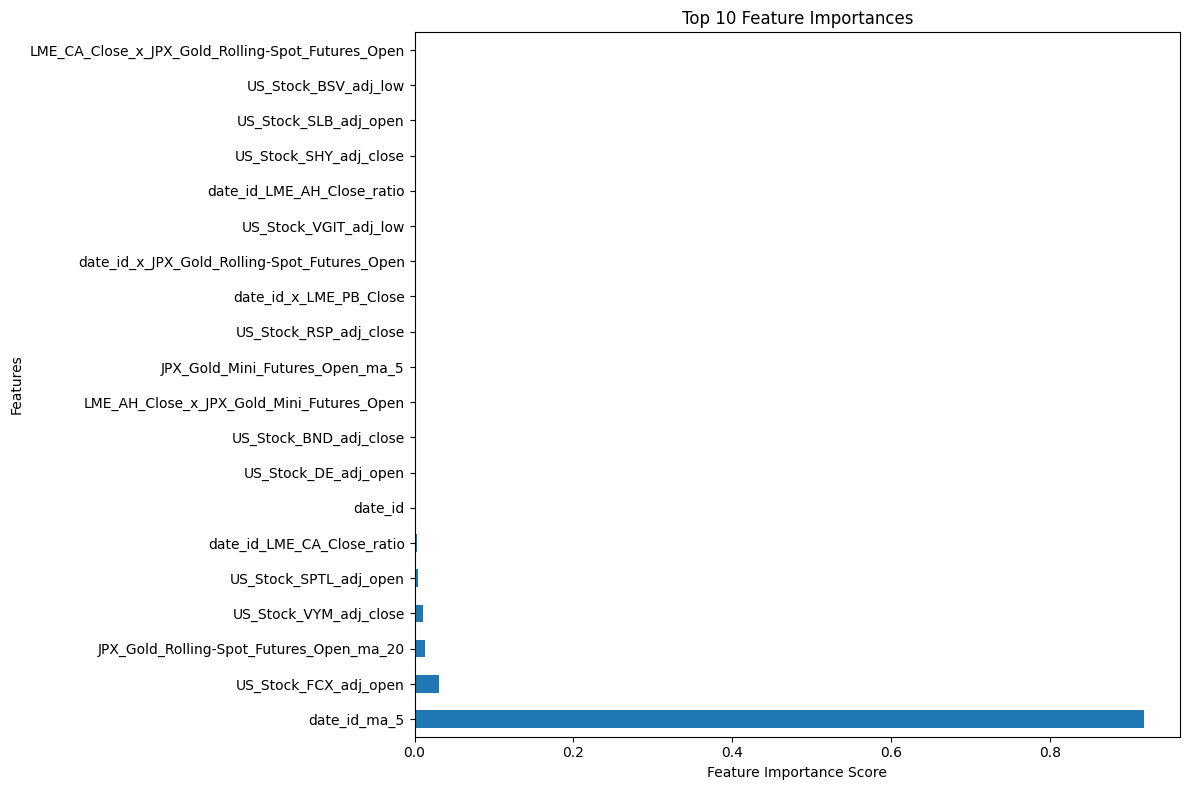

In [48]:
# # Create and train the model
# def train_baseline_model(model, X_train, y_train, X_val, y_val):
#     assert not np.isnan(X_train).any(), "NaN in training features"
#     assert not np.isnan(y_train).any(), "NaN in training labels"
#     assert not np.isinf(X_train).any(), "Inf in training features"
#     assert not np.isinf(y_train).any(), "Inf in training labels"
    
#     start_time = time.time()
    
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         early_stopping_rounds=20,
#         verbose=10
#     )
    
#     train_time = time.time() - start_time
#     print(f" Baseline Vanilla XGBoost model training time: {train_time:.2f} seconds")
    
#     # Make predictions
#     val_preds = model.predict(X_val)
    
#     # Calculate competition metric
#     val_solution = pd.DataFrame(y_val, columns=[f'target_{i}' for i in range(y_val.shape[1])])
#     val_submission = pd.DataFrame(val_preds, columns=[f'target_{i}' for i in range(y_val.shape[1])])
    
#     # Add row_id for metric calculation
#     val_solution['row_id'] = range(len(val_solution))
#     val_submission['row_id'] = range(len(val_submission))
    
#     score_val = competition_score(val_solution, val_submission, 'row_id')
#     print(f" Baseline Vanilla XGBoost model validation score (Sharpe ratio):  {score_val:.4f}")
    
#     # Compute feature importances
#     if hasattr(model, 'feature_importances_'):
#         plt.figure(figsize=(12, 8))
#         # Visualize top-20 most important features
#         feat_importances = pd.Series(model.feature_importances_, index=train_eng.columns).sort_values(ascending=True)
#         feat_importances.nlargest(10).plot(kind='barh')
#         plt.title('Top 10 Feature Importances')
#         plt.xlabel('Feature Importance Score') 
#         plt.ylabel('Features') 
#         plt.tight_layout()
#         plt.show()
        
#     return model, val_preds, score_val

# # Train vanilla XGBoost model
# model, val_preds, baseline_score = train_baseline_model(model, X_train, y_train, X_val, y_val)

#### Hyperparameter Optimization
- Define function to optimize the baseline vanilla XGBoost model using RandomSearchCV.

In [ ]:
def optimize_model(X_train, y_train, X_val, y_val, gpu_available=False):  
    # Define param grid
    param_dist = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 9, 11],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'min_child_weight': [1, 3, 5, 7],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0.5, 1.0, 1.5, 2.0]
    }
    
    # Set device
    if gpu_available:
        param_dist['tree_method'] = ['gpu_hist']
    else:
        param_dist['tree_method'] = ['auto']
    
    print("Starting RandomizedSearchCV...")
    print(f"Parameter grid size: {np.prod([len(v) for v in param_dist.values()])} combinations")
    print(f"Sampling 20 parameter combinations")
    
    # Perform a Time series split for validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Create base model
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=20,  
        scoring=competition_scorer,
        cv=tscv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    random_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    
    print(f"\nRandomizedSearchCV optimization time: {search_time:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validated score: {random_search.best_score_:.4f}")
    
    # Train the best param model on training set
    best_params = random_search.best_params_
    best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
    
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=20,
        verbose=10
    )
    
    # Evaluate optimized XGBoost model on validation set
    val_preds = best_model.predict(X_val)
    val_solution = pd.DataFrame(y_val, columns=[f'target_{i}' for i in range(y_val.shape[1])])
    val_submission = pd.DataFrame(val_preds, columns=[f'target_{i}' for i in range(y_val.shape[1])])
    val_solution['row_id'] = range(len(val_solution))
    val_submission['row_id'] = range(len(val_submission))
    
    optimized_score = competition_score(val_solution, val_submission, 'row_id')
    print(f" Optimized XGBoost model validation score (Sharpe ratio): {optimized_score:.4f}")
    print(f" Improvement over baseline: {(optimized_score - baseline_score) / abs(baseline_score) * 100:.2f}%")
    
    return best_model, best_params, optimized_score

# Optimize baseline XGboost model using RandomSearchCV()
best_model, best_params, optimized_score = optimize_model(X_train, y_train, X_val, y_val, GPU_AVAILABLE)

Starting RandomizedSearchCV...
Parameter grid size: 640000 combinations
Sampling 20 parameter combinations
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=2.0, subsample=0.9, tree_method=gpu_hist; total time= 6.4min
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.8, tree_method=gpu_hist; total time=17.0min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

In [ ]:
# Optimized XGBoost model evaluation
print("\n RandomSearchCV optimized XGBoost Model Evaluation")
print(f"Baseline model score: {baseline_score:.4f}")
print(f"Optimized model score: {optimized_score:.4f}")

# Save optimized model
model_filename = 'xgboost_model.pkl'
joblib.dump(best_model, model_filename)
print(f"\n Model saved to {model_filename}")

### XGBoost Model Evaluation and Inference Setup

In [ ]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import kaggle_evaluation.mitsui_inference_server

NUM_TARGET_COLUMNS = 424

model = None

def predict(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pd.DataFrame:

    global model
    if model is None:
        start_time = time.time()
        print(" Load model for first prediction...")
        
        model_path = 'xgboost_model.pkl'

    # Convert Polars DataFrame to Pandas for processing
    test_pd = test.to_pandas()
    
    # Perform feature engineering on test set
    # Engineer date-based features
    if 'date' in test_pd.columns:
        test_pd['date'] = pd.to_datetime(test_pd['date'])
        test_pd['day_of_week'] = test_pd['date'].dt.dayofweek
        test_pd['month'] = test_pd['date'].dt.month
        test_pd['quarter'] = test_pd['date'].dt.quarter
        test_pd['is_weekend'] = test_pd['day_of_week'].isin([5, 6]).astype(int)
        test_pd = test_pd.drop('date', axis=1)
    
    # Engineer rank normalization for numeric features
    numeric_cols = test_pd.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Rank and convert to percentile
        test_pd[col] = test_pd[col].rank(pct=True).fillna(0.5)
    
    # Handle any remaining NaNs
    test_pd = test_pd.fillna(0.5)
    
    # Make prediction (one row per batch in the API)
    try:
        prediction = model.predict(test_pd)[0]
    except Exception as e:
        print(f" Prediction error: {str(e)} - using zeros")
        prediction = np.zeros(NUM_TARGET_COLUMNS)
    
    # Format output as Pandas DataFrame 
    predictions = pd.DataFrame({
        f'target_{i}': [float(prediction[i])] for i in range(NUM_TARGET_COLUMNS)
    })
    
    # Verify output 
    assert isinstance(predictions, pd.DataFrame), "Output must be a Pandas DataFrame"
    assert len(predictions) == 1, "Output must contain exactly one row"
    assert predictions.shape[1] == NUM_TARGET_COLUMNS, f"Output must have {NUM_TARGET_COLUMNS} columns"
    
    return predictions

### Submission

In [ ]:
import kaggle_evaluation.mitsui_inference_server

# Instantiate inference server
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

# Finetune the TabTransformer Model

In [ ]:
# !pip install torch pytorch-tabular pandas numpy scikit-learn matplotlib seaborn polars tqdm

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_tabular import TabTransformerModel
from pytorch_tabular.config import (
    DataConfig, 
    TabTransformerConfig, 
    TrainerConfig,
    OptimizerConfig
)
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

In [ ]:
# Data preparation
def prepare_tabtransformer_data(train_eng, train_labels):
    X = train_eng.copy()
    y = train_labels.copy()
    
    categorical_cols = []
    for col in X.columns:
        # Treat features with less than 20 unique values as categorical
        if X[col].dtype in ['int64', 'int32'] and X[col].nunique() <= 20:
            categorical_cols.append(col)
        # Treat date-related features as categorical
        elif 'day_of_week' in col.lower() or 'month' in col.lower() or 'quarter' in col.lower():
            categorical_cols.append(col)
    
    print(f"Identified {len(categorical_cols)} potential categorical features:")
    for col in categorical_cols[:5]:
        print(f" - {col} (unique values: {X[col].nunique()})")
    if len(categorical_cols) > 5:
        print(f" ... and {len(categorical_cols)-5} more")
    
    # The feautures with float/ interger values as numerical
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    print(f"\nUsing {len(numerical_cols)} numerical features")
    
    # Create target columns 
    target_cols = [f'target_{i}' for i in range(y.shape[1])]
    y.columns = target_cols
    
    # Combine features and targets for TabTransformer
    full_df = pd.concat([X, y], axis=1)
    
    print(f"\nFinal dataset shape: {full_df.shape}")
    print(f"Features: {len(categorical_cols) + len(numerical_cols)} | Targets: {len(target_cols)}")
    
    return full_df, categorical_cols, numerical_cols, target_cols

# Prepare dataset for transfer learning
full_df, categorical_cols, numerical_cols, target_cols = prepare_tabtransformer_data(train_eng_clean, train_labels_clean)

In [ ]:
# Define function to create pretraining dataset with masked feature prediction
def create_pretraining_data(full_df, categorical_cols, numerical_cols):
    pretrain_df = full_df.copy()
    
    # Randomly mask 15% of the features
    mask_prob = 0.15
    mask_token = -9999  # Assing the the value -9999 to indicate masked features
    
    # Create masks for categorical and numerical features
    cat_masks = np.random.rand(len(pretrain_df), len(categorical_cols)) < mask_prob
    num_masks = np.random.rand(len(pretrain_df), len(numerical_cols)) < mask_prob
    
    # Store original values for evaluation
    cat_original = pretrain_df[categorical_cols].values.copy()
    num_original = pretrain_df[numerical_cols].values.copy()
    
    # Apply masks
    pretrain_df[categorical_cols] = np.where(
        cat_masks, 
        mask_token, 
        pretrain_df[categorical_cols].values
    )
    
    pretrain_df[numerical_cols] = np.where(
        num_masks, 
        mask_token, 
        pretrain_df[numerical_cols].values
    )
    
    # Add columns to indicate masked features
    for i, col in enumerate(categorical_cols):
        pretrain_df[f'{col}_mask'] = cat_masks[:, i].astype(int)
    
    for i, col in enumerate(numerical_cols):
        pretrain_df[f'{col}_mask'] = num_masks[:, i].astype(int)
    
    # Create target columns for pretraining
    for i, col in enumerate(categorical_cols):
        pretrain_df[f'{col}_target'] = cat_original[:, i]
    
    for i, col in enumerate(numerical_cols):
        pretrain_df[f'{col}_target'] = num_original[:, i]
    
    print(f"Masked {cat_masks.sum() + num_masks.sum()} features ({mask_prob*100:.1f}%)")
    print(f"Added {len(categorical_cols) + len(numerical_cols)} target columns for pretraining")
    
    return pretrain_df

# Create pretraining dataset
pretrain_df = create_pretraining_data(full_df, categorical_cols, numerical_cols)

In [ ]:
# Define function to configure and pretrain the TabTransformer model
def configure_and_pretrain(pretrain_df, categorical_cols, numerical_cols):
    # Define target columns
    cat_target_cols = [f'{col}_target' for col in categorical_cols]
    num_target_cols = [f'{col}_target' for col in numerical_cols]
    all_target_cols = cat_target_cols + num_target_cols
    
    # Define mask columns 
    cat_mask_cols = [f'{col}_mask' for col in categorical_cols]
    num_mask_cols = [f'{col}_mask' for col in numerical_cols]
    
    # Update feature lists to include mask columns
    pretrain_categorical_cols = categorical_cols + cat_mask_cols
    pretrain_numerical_cols = numerical_cols + num_mask_cols
    
    # Data configuration
    data_config = DataConfig(
        target=[
            # Categorical targets
            *[{'name': col, 'task': 'classification', 'classes': int(pretrain_df[col].nunique())} 
              for col in cat_target_cols],
            # Numerical targets
            *[{'name': col, 'task': 'regression'} for col in num_target_cols]
        ],
        continuous_cols=pretrain_numerical_cols,
        categorical_cols=pretrain_categorical_cols,
        # Train-validation split
        validation_split=0.2,
    )
    
    # Model configuration
    model_config = TabTransformerConfig(
        task="regression",
        learning_rate=5e-4,
        batch_size=256,
        virtual_batch_size=64,
        num_transformer_blocks=2,
        num_heads=4,
        dropout=0.1,
        embedding_dim=32,
        output_dim=len(all_target_cols),
    )
    
    # Optimizer configuration
    optimizer_config = OptimizerConfig()
    
    # Trainer configuration
    trainer_config = TrainerConfig(
        auto_lr_find=True,  
        batch_size=256,
        max_epochs=10, 
        gpus=-1 if device == 'cuda' else 0,  
        early_stopping_patience=3,
        early_stopping_monitor="val_loss",
    )
    
    print(f"Using {model_config.num_transformer_blocks} transformer blocks")
    print(f"Using {model_config.num_heads} attention heads")
    print(f"Embedding dimension: {model_config.embedding_dim}")
    
    # Create and train the model
    start_time = time.time()
    model = TabTransformerModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
    )
    
    model.fit(
        train=pretrain_df,
    )
    
    pretrain_time = time.time() - start_time
    print(f"\ Pretraining time: {pretrain_time:.2f} seconds")
    
    # Evaluate pretraining performance
    pretrain_results = model.evaluate(pretrain_df)
    print(f"Training loss: {pretrain_results[0]['train_loss']:.4f}")
    print(f"Validation loss: {pretrain_results[0]['val_loss']:.4f}")
    
    return model

# Pretrain the model
pretrained_model = configure_and_pretrain(pretrain_df, categorical_cols, numerical_cols)

In [ ]:
# Finetune pretrained TabTransformer model
def finetune_for_prediction(pretrained_model, full_df, categorical_cols, numerical_cols, target_cols):
    
    # Perform time-based train-validation split
    split_idx = int(0.8 * len(full_df))
    train_df = full_df.iloc[:split_idx].reset_index(drop=True)
    val_df = full_df.iloc[split_idx:].reset_index(drop=True)
    
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    
    # Configure fine-tuning data
    data_config = DataConfig(
        target=target_cols,
        continuous_cols=numerical_cols,
        categorical_cols=categorical_cols,
        validation_split=None,  
    )
    
    # Model configuration 
    model_config = TabTransformerConfig(
        task="regression",
        learning_rate=1e-4, 
        batch_size=256,
        virtual_batch_size=64,
        num_transformer_blocks=pretrained_model.model_config.num_transformer_blocks,
        num_heads=pretrained_model.model_config.num_heads,
        dropout=pretrained_model.model_config.dropout,
        embedding_dim=pretrained_model.model_config.embedding_dim,
        output_dim=len(target_cols),
    )
    
    # Optimizer configuration
    optimizer_config = OptimizerConfig()
    
    # Trainer configuration
    trainer_config = TrainerConfig(
        auto_lr_find=False,
        batch_size=256,
        max_epochs=20,
        gpus=-1 if device == 'cuda' else 0,
        early_stopping_patience=5,
        early_stopping_monitor="val_loss",
        checkpoints="best", 
        load_best=True, 
    )
        
    start_time = time.time()
    finetune_model = TabTransformerModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
    )
    
    # Transfer weights from pretrained model
    finetune_model.model.load_state_dict(pretrained_model.model.state_dict(), strict=False)
    finetune_model.fit(
        train=train_df,
        validation=val_df,
    )
    
    finetune_time = time.time() - start_time
    print(f"\n Fine-tuning time: {finetune_time:.2f} seconds")
    
    # Evaluate fine-tuned model
    val_results = finetune_model.evaluate(val_df)
    print(f"Validation loss: {val_results[0]['val_loss']:.4f}")
    val_preds = finetune_model.predict(val_df)
    
    # Extract the prediction columns
    pred_cols = [col for col in val_preds.columns if col.startswith('prediction')]
    val_preds_array = val_preds[pred_cols].values
    
    # Compute competition metric
    val_solution = val_df[target_cols].copy()
    val_submission = pd.DataFrame(val_preds_array, columns=target_cols)
    
    # Add row_id 
    val_solution['row_id'] = range(len(val_solution))
    val_submission['row_id'] = range(len(val_submission))
    
    finetune_score = competition_score(val_solution, val_submission, 'row_id')
    print(f" Fine-tuned TabTransformer validation score (Sharpe ratio): {finetune_score:.4f}")
    
    return finetune_model, finetune_score

# Fine-tune the model
finetune_model, finetune_score = finetune_for_prediction(
    pretrained_model, full_df, categorical_cols, numerical_cols, target_cols
)

In [ ]:
# Define function to export finetuned TbTransformer model as a zip file
import os
import zipfile
import json
import time
from datetime import datetime

def export_tabtransformer_model(finetune_model, categorical_cols, numerical_cols, target_cols, finetune_score):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f"finetuned-tabtransformer{timestamp}"
    os.makedirs(model_dir, exist_ok=True)
    finetune_model.save_model(model_dir)
    print(f" Finetuned TabTransformer model saved to directory: {model_dir}")

### Finetuned TabTransformer Model Evaluation and Inference Setup

In [ ]:
# Inference
import os
import time
import joblib
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import kaggle_evaluation.mitsui_inference_server

NUM_TARGET_COLUMNS = 424

model = None

def predict(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pd.DataFrame:

    global model
    if model is None:
        start_time = time.time()
        print(" Load model for prediction")
        
        model_path = 'finetune_model'

    # Convert Polars DataFrame to Pandas for processing
    test_pd = test.to_pandas()
    
    # Perform feature engineering on test set
    # Engineer date-based features
    if 'date' in test_pd.columns:
        test_pd['date'] = pd.to_datetime(test_pd['date'])
        test_pd['day_of_week'] = test_pd['date'].dt.dayofweek
        test_pd['month'] = test_pd['date'].dt.month
        test_pd['quarter'] = test_pd['date'].dt.quarter
        test_pd['is_weekend'] = test_pd['day_of_week'].isin([5, 6]).astype(int)
        test_pd = test_pd.drop('date', axis=1)
    
    # Engineer rank normalization for numeric features
    numeric_cols = test_pd.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Rank and convert to percentile
        test_pd[col] = test_pd[col].rank(pct=True).fillna(0.5)
    
    # Handle any remaining NaNs
    test_pd = test_pd.fillna(0.5)
    
    # Make prediction (one row per batch in the API)
    try:
        prediction = model.predict(test_pd)[0]
    except Exception as e:
        print(f" Prediction error: {str(e)} - using zeros")
        prediction = np.zeros(NUM_TARGET_COLUMNS)
    
    # Format output as Pandas DataFrame 
    predictions = pd.DataFrame({
        f'target_{i}': [float(prediction[i])] for i in range(NUM_TARGET_COLUMNS)
    })
    
    # Verify output 
    assert isinstance(predictions, pd.DataFrame), "Output must be a Pandas DataFrame"
    assert len(predictions) == 1, "Output must contain exactly one row"
    assert predictions.shape[1] == NUM_TARGET_COLUMNS, f"Output must have {NUM_TARGET_COLUMNS} columns"
    
    return predictions

### Submission

In [ ]:
import kaggle_evaluation.mitsui_inference_server

# Instantiate inference server
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))